In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('Mall_Customers.csv')

In [3]:
data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
data.drop(columns = ['CustomerID'], inplace = True)

In [6]:
data['Gender'] = data['Gender'].replace({'Male': 1, 'Female': 0})

In [7]:
data.describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,0.440000,38.850000,60.560000,50.200000
std,0.497633,13.969007,26.264721,25.823522
min,0.000000,18.000000,15.000000,1.000000
25%,0.000000,28.750000,41.500000,34.750000
50%,0.000000,36.000000,61.500000,50.000000
75%,1.000000,49.000000,78.000000,73.000000
max,1.000000,70.000000,137.000000,99.000000


In [8]:
from sklearn.cluster import AgglomerativeClustering

AC = AgglomerativeClustering(n_clusters = 3)

In [9]:
data.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

In [13]:
x = data[['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

AC.fit(x)

AgglomerativeClustering(n_clusters=3)

In [14]:
y_predict = AC.fit_predict(x)

In [16]:
import pandas as pd

clust_df = pd.DataFrame(y_predict)

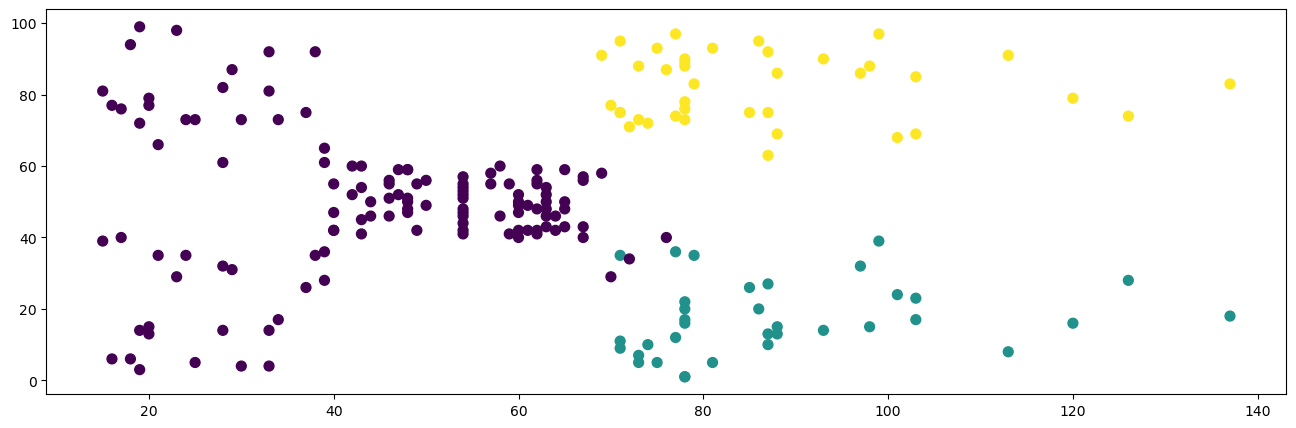

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (16, 5))
ax = fig.add_subplot(1,1,1)
scatter = ax.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'], s = 50, c = clust_df[0])

In [19]:
clust_df.value_counts()

0    126
2     39
1     35
Name: count, dtype: int64

In [20]:
x

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40
...,...,...,...,...
195,0,35,120,79
196,0,45,126,28
197,1,32,126,74
198,1,32,137,18
